### Compare results from PyGEM for a parameter grid search with elevation change observations

Comparing multiple glaciers


In [1]:
### imports ###
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import xarray as xr
import numpy as np
import scipy
from scipy.stats import norm
import os, glob, sys, warnings, shutil,random
import cftime, datetime, pickle, json
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import cmocean
from tqdm import tqdm


/Users/albinwells/mambaforge/envs/oggm_env_emulator/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
sys.path.append("/Users/albinwells/Desktop/PyGEM-docs/PyGEM-scripts")
sys.path.append("/Users/albinwells/Desktop/PyGEM-docs/PyGEM")

import pygem
import pygem.pygem_modelsetup as modelsetup
import pygem_input as pygem_prms


In [3]:
# figure settings
plt.rcParams["font.family"] = "arial"
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10

figsize=(8,5)
cmap = cmocean.cm.matter_r
%matplotlib inline


# Plot PyGEM modeled mass balance for a range of $k_p$, $T_{bias}$, and $f_{snow}$

In [5]:
# data dir
sim_dir = '/Users/albinwells/Desktop/PyGEM-docs/Output/simulations/gridsearch/01/ERA5/'
error_metric = 'mad'    # either 'mad', or 'rmse'
geodetic_filt = True
weighted = True


In [6]:
# list unique glaciers we have results for (1.15645 is Kennicott, 1.26722 is Root)
fns = glob.glob(sim_dir+'stats/*.nc')
glacnos = np.asarray([fn.split('/')[-1].split('_')[0] for fn in fns])
glacnos = list(np.unique(glacnos))
glacnos

['1.15645', '1.26722']

In [7]:
# select which glaciers to compare
glacnos = glacnos[:]
glacnos


['1.15645', '1.26722']

In [8]:
# instantiate arrays to hold values we'll later plot
years, glac_nos, dfs = [], [], []
for glacno in glacnos:
    kps, tbiass, ddfsnows = [], [], []
    mbs, mbs_annual = [], []
    
    # list of the set string
    setstring = []
    
    for i, f in enumerate(glob.glob(sim_dir+f'stats/*{glacno}*1940*2022*.nc')):
        kp = f.split('/')[-1].split('_kp')[1].split('_')[0]
        tbias = f.split('/')[-1].split('_tbias')[1].split('_')[0]
        ddfsnow = f.split('/')[-1].split('_ddfsnow')[1].split('_')[0]
        ds = xr.open_dataset(f)
        glac_massbaltotal_monthly = ds['glac_massbaltotal_monthly'].values[0]
        # get running mass balance for each year
        glac_running_massbaltotal_monthly = np.reshape(glac_massbaltotal_monthly, (-1,12), order='C').cumsum(axis=-1)
        # total for a given year is last value in each year
        glac_massbaltotal_annual = glac_running_massbaltotal_monthly[:,-1]
        # divide by area to get specific annual mb
        glac_spec_massbaltotal_annual = glac_massbaltotal_annual / ds['glac_area_annual'].values[0][:-1]
        # get average value
        glac_avg_spec_massbaltotal_annual = np.nanmean(glac_spec_massbaltotal_annual)
    
        # append vals to running arrays
        kps.append(kp)
        tbiass.append(tbias)
        ddfsnows.append(ddfsnow)
        mbs.append(glac_avg_spec_massbaltotal_annual) # mean of all mbs
        mbs_annual.append(glac_spec_massbaltotal_annual)
        setstring.append(f'kp{kp}_ddfsnow{ddfsnow}_tbias{tbias}')
    
    years.append(np.array(ds.year))
    glac_nos.append(f.split('/')[-1].split('_')[0])
    # create df of output
    df = pd.DataFrame({'kp':[float(x) for x in kps],"tbias":[float(x) for x in tbiass],
                       "ddfsnow":1e3*np.asarray([float(x) for x in ddfsnows]),"mb":mbs, "mb_annual":mbs_annual, "paramstr":setstring})
    dfs.append(df)


Glacier 1.15645
Glacier 1.26722


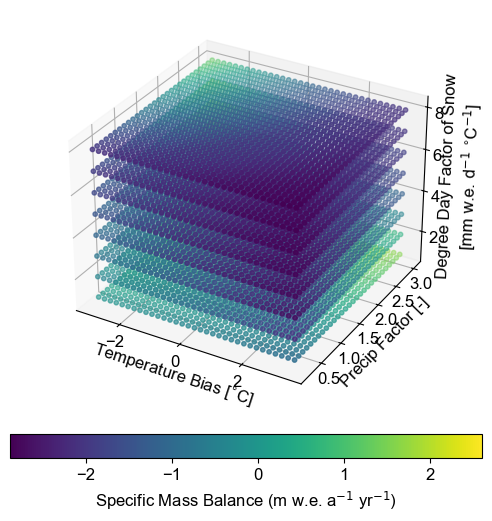

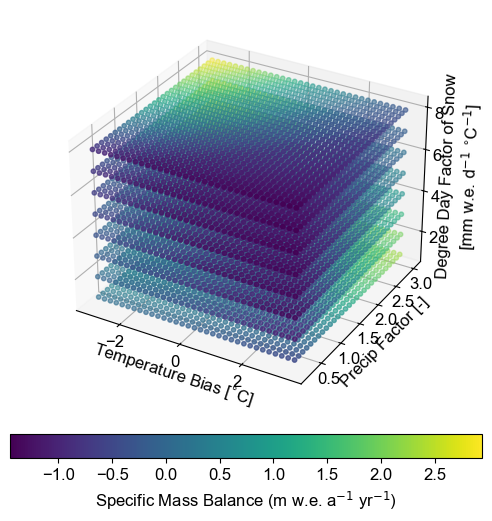

In [9]:
for df, glacno in zip(dfs, glac_nos):
    print('Glacier', glacno)
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'},
                           gridspec_kw=dict(top=1.05, bottom=.05, left=-.05, right=.85), figsize=(7,5))
    
    s = 10
    pad=.2
    pad = '10%'
    size = '3%'
    
    c = ax.scatter(xs=df['tbias'], ys=df['kp'], zs=df['ddfsnow'], c=df['mb'], cmap=plt.cm.viridis, s=s)
    
    ax.set_xlabel(r'Temperature Bias [$^{\circ}$C]', labelpad=-7)
    ax.set_ylabel('Precip Factor [-]', labelpad=-7)
    ax.set_zlabel('Degree Day Factor of Snow\n' + r'[mm w.e. d$^{-1}$ $^{\circ}$C$^{-1}$]', labelpad=-5)
    ax.tick_params(axis="x", pad=-3) # (+) Added
    ax.tick_params(axis="y", pad=-3) # (+) Added
    ax.tick_params(axis="z", pad=-3) # (+) Added
    
    
    fig.colorbar(c, label=r'Specific Mass Balance (m w.e. a$^{-1}$ yr$^{-1}$)', pad=.05,shrink=.75, orientation='horizontal') # an example
    os.makedirs(f'/Users/albinwells/Desktop/PyGEM-docs/Output/simulations/gridsearch/figs/{glacno}/', exist_ok=True)
    fig.savefig(f'/Users/albinwells/Desktop/PyGEM-docs/Output/simulations/gridsearch/figs/{glacno}/{glacno}_mb.png',dpi=300)


Create plot similar to Rounce et al. (2020), Fig 2

## See which parameter set simulations agree with geodetic data from Hugonett et al. (2021)

In [10]:
hug_df = pd.read_csv('/Users/albinwells/Desktop/PyGEM-docs/DEMs/Hugonnet2020/df_pergla_global_20yr-filled-FAcorrected.csv')
hug_df.head()

RGIId  valid_obs                 period      area  perc_area_meas  \
0  RGI60-01.00001  26.405405  2000-01-01_2020-01-01  0.359903        1.000000   
1  RGI60-01.00002  26.210526  2000-01-01_2020-01-01  0.557795        1.000000   
2  RGI60-01.00003  16.752941  2000-01-01_2020-01-01  1.684078        1.000000   
3  RGI60-01.00004  16.847826  2000-01-01_2020-01-01  3.678055        0.994565   
4  RGI60-01.00005  19.555985  2000-01-01_2020-01-01  2.571437        1.000000   

         lat         lon       err_cont  perc_err_cont    dmdtda  ...  reg  \
0  63.689068 -146.823302   40903.798036      11.365238 -0.012784  ...  1.0   
1  63.403937 -146.667759   62195.460607      11.150240 -0.229046  ...  1.0   
2  63.376338 -146.079804   92102.483020       5.469016 -0.797923  ...  1.0   
3  63.380820 -146.120299  228295.126481       6.206952 -0.407478  ...  1.0   
4  63.550571 -147.057500  140479.507870       5.463073  0.038993  ...  1.0   

           t1          t2  O1Region   mb_mwea mb_mwea_err  mb_romain_mwea  \
0  2000-01-01  2020-01-01       1.0 -0.012784    0.217559       -0.012784   
1  2000-01-01  2020-01-01       1.0 -0.229046    0.145960       -0.229046   
2  2000-01-01  2020-01-01       1.0 -0.797923    0.166884       -0.797923   
3  2000-01-01  2020-01-01       1.0 -0.407478    0.141631       -0.407478   
4  2000-01-01  2020-01-01       1.0  0.038993    0.141970        0.038993   

   mb_romain_mwea_err  mb_clim_mwea  mb_clim_mwea_err  
0            0.217559     -0.012784          0.217559  
1            0.145960     -0.229046          0.145960  
2            0.166884     -0.797923          0.166884  
3            0.141631     -0.407478          0.141631  
4            0.141970      0.038993          0.141970  

[5 rows x 23 columns]

We'll compare the PyGEM modeled annual mass balance with that from Hugonnet

In [11]:
hug_mbs, hug_mberrors = [], []
for glacno in glac_nos:
    hug_df = pd.read_csv('/Users/albinwells/Desktop/PyGEM-docs/DEMs/Hugonnet2020/df_pergla_global_20yr-filled-FAcorrected.csv')
    rgi6id = glacno.split('.')[0].zfill(2) + '.' + glacno.split('.')[1]
    hug_df = hug_df.loc[hug_df.apply(lambda x: x.RGIId == 'RGI60-'+rgi6id, axis=1)]
    hug_mb = hug_df['mb_mwea'].tolist()[0]
    hug_mberror = hug_df['mb_mwea_err'].tolist()[0]

    hug_mbs.append(hug_mb)
    hug_mberrors.append(hug_mberror)


Retrieve ablation area mass balance rates from our DEMs

In [12]:
def calc_avg_mb(mb_annual, start_yr, end_yr):
    # averages annual mb from start_yr to end_yr
        # e.g.: start_yr=2000, end_yr=2020 averages all mb 2000-2019 (so it is UP TO 2020, but not including)
    start_i = start_yr - 1940
    end_i = end_yr - 1940
    # print('Averaging mass balace from', years[start_i], 'up to', years[end_i])
    return sum(mb_annual[start_i:end_i]) / len(mb_annual[start_i:end_i])
    

In [13]:
# get multi-year mass balance average
dfns = []
for df in dfs:
    df[f'avg_mb_1940_1957'] = df['mb_annual'].apply(calc_avg_mb, args=(1940, 1957))
    df[f'avg_mb_1957_1978'] = df['mb_annual'].apply(calc_avg_mb, args=(1957, 1978))
    df[f'avg_mb_1978_2004'] = df['mb_annual'].apply(calc_avg_mb, args=(1978, 2004))
    df[f'avg_mb_2000_2020'] = df['mb_annual'].apply(calc_avg_mb, args=(2000, 2020))
    
    # drop the column with arrays in new df
    dfn = df.copy()
    dfn.drop('mb_annual', axis=1, inplace=True)
    dfns.append(dfn)


Filter stats solutions by which are closest to known mass balance

In [94]:
# filter to only match observations
df_filt_alls, sets_accepts = [], []
for i, (glacno, dfn) in enumerate(zip(glac_nos, dfns)):
    acc_err = 0.12 * 0.9 # error due to only measuring ablation area
    kenn_abar = 108/292 # ablation area ratio
    root_abar = 32/82
    kenn_err_add = 0.075 # adding additional error for Kennicott
    root_err_add = 0.075 # adding additional error for Root
    hug_mberr_add = 0.075 # adding additional error to Hugonnet mb
    if glacno == '1.15645': # Kennicott (convert dhdt to m w.e.)
        hdem_mb_1940_1957 = 0.0
        hdem_mberr_1940_1957 = (0.441 * 0.9 * kenn_abar + kenn_err_add)
        hdem_mb_1957_1978 = -0.441 * 0.9 * kenn_abar
        hdem_mberr_1957_1978 = (0.018 * 0.9 * kenn_abar) + acc_err + kenn_err_add
        hdem_mb_1978_2004 = -0.720 * 0.9 * kenn_abar
        hdem_mberr_1978_2004 = (0.030 * 0.9 * kenn_abar) + acc_err + kenn_err_add
    elif glacno == '1.26722': # Root (convert dhdt to m w.e.)
        hdem_mb_1940_1957 = 0.0
        hdem_mberr_1940_1957 = 0.245 * 0.9 * root_abar + root_err_add
        hdem_mb_1957_1978 = -0.245 * 0.9 * root_abar
        hdem_mberr_1957_1978 = (0.015 * 0.9 * root_abar) + acc_err + root_err_add
        hdem_mb_1978_2004 = -0.787 * 0.9 * root_abar
        hdem_mberr_1978_2004 = (0.050 * 0.9 * root_abar) + acc_err + root_err_add

    # filter only solutions that work for ALL time periods
    df_filt1 = dfn[(dfn['avg_mb_2000_2020']>hug_mbs[i]-(hug_mberrors[i]+hug_mberr_add)) & 
                   (dfn['avg_mb_2000_2020']<hug_mbs[i]+(hug_mberrors[i]+hug_mberr_add))]
    df_filt2 = dfn[(dfn['avg_mb_1940_1957']>hdem_mb_1940_1957-hdem_mberr_1940_1957) & 
                   (dfn['avg_mb_1940_1957']<hdem_mb_1940_1957+(hdem_mberr_1940_1957)*0.1)]
    df_filt3 = dfn[(dfn['avg_mb_1957_1978']>hdem_mb_1957_1978-hdem_mberr_1957_1978) & 
                   (dfn['avg_mb_1957_1978']<hdem_mb_1957_1978+hdem_mberr_1957_1978)]
    df_filt4 = dfn[(dfn['avg_mb_1978_2004']>hdem_mb_1978_2004-hdem_mberr_1978_2004) & 
                   (dfn['avg_mb_1978_2004']<hdem_mb_1978_2004+hdem_mberr_1978_2004)]

    # only keep rows that match all the mass balance criteria
    df_filt_all = dfn.merge(df_filt1)
    df_filt_all = df_filt_all.merge(df_filt2)
    df_filt_all = df_filt_all.merge(df_filt3)
    df_filt_all = df_filt_all.merge(df_filt4)
    df_filt_alls.append(df_filt_all)

    print('Param sets for Glacier '+glacno+':', len(df_filt1), len(df_filt2), len(df_filt3), len(df_filt4),
          '\t TOTAL:', len(df_filt_all))
    
    sets_accept = df_filt_all['paramstr'].tolist()
    sets_accepts.append(sets_accept)

print('\n\t OVERLAPPING SETS:', len(pd.merge(df_filt_alls[0], df_filt_alls[1], on=['kp', 'tbias', 'ddfsnow'])))


Param sets for Glacier 1.15645: 1363 325 438 567 	 TOTAL: 101
Param sets for Glacier 1.26722: 613 326 775 970 	 TOTAL: 39

	 OVERLAPPING SETS: 0


In [95]:
df_filt_alls[0].sort_values(['kp']).head(10)


kp  tbias  ddfsnow        mb                      paramstr  \
97   0.2   -1.2      1.0 -0.242082  kp0.2_ddfsnow0.001_tbias-1.2   
2    0.2   -1.4      1.0 -0.219044  kp0.2_ddfsnow0.001_tbias-1.4   
45   0.3   -3.0      2.0 -0.260890  kp0.3_ddfsnow0.002_tbias-3.0   
20   0.3   -0.2      1.0 -0.256036  kp0.3_ddfsnow0.001_tbias-0.2   
80   0.3   -0.4      1.0 -0.229678  kp0.3_ddfsnow0.001_tbias-0.4   
74   0.3   -2.8      2.0 -0.297579  kp0.3_ddfsnow0.002_tbias-2.8   
38   0.3   -0.6      1.0 -0.203653  kp0.3_ddfsnow0.001_tbias-0.6   
100  0.4    0.6      1.0 -0.262284   kp0.4_ddfsnow0.001_tbias0.6   
39   0.4   -2.2      2.0 -0.294935  kp0.4_ddfsnow0.002_tbias-2.2   
21   0.4   -2.6      2.0 -0.214587  kp0.4_ddfsnow0.002_tbias-2.6   

     avg_mb_1940_1957  avg_mb_1957_1978  avg_mb_1978_2004  avg_mb_2000_2020  
97          -0.153316         -0.204450         -0.254029         -0.324197  
2           -0.133105         -0.182785         -0.230811         -0.298224  
45          -0.128845         -0.205151         -0.281616         -0.381132  
20          -0.153689         -0.216861         -0.270155         -0.347981  
80          -0.129859         -0.191676         -0.242880         -0.319278  
74          -0.159943         -0.239118         -0.319178         -0.423254  
38          -0.106767         -0.167023         -0.216385         -0.290272  
100         -0.149549         -0.222068         -0.277726         -0.362536  
39          -0.143868         -0.234562         -0.316523         -0.431251  
21          -0.075482         -0.160146         -0.235284         -0.338410

# Compare PyGEM modeled change in surface elevation for a range of $k_p$, $T_{bias}$, and $f_{snow}$ to DEM $dhdt$ observations

In [96]:
### functions ###
def rmse(y_actual, y_predicted, weights=None):
    if weights is not None:
        indices = np.where(np.logical_and(~np.isnan(y_actual), ~np.isnan(y_predicted)))[0]
        return np.average(np.square(np.subtract(y_actual[indices],y_predicted[indices])), weights=weights[indices] / np.nanmax(weights[indices]))
    else:    
        return np.nanmean(np.square(np.subtract(y_actual,y_predicted))) 


def mad(y_actual, y_predicted, weights=None):
    if weights is not None:
        indices = np.where(np.logical_and(~np.isnan(y_actual), ~np.isnan(y_predicted)))[0]
        return np.average(np.abs(np.subtract(y_actual[indices],y_predicted[indices])), weights=weights[indices] / np.nanmax(weights[indices]))
    else:
        return np.nanmean(np.abs(np.subtract(y_actual,y_predicted)))
        

def filter_on_pixel_count(arr, filt = None):
    """
    create a mask based on the pixel count per elevation bin
    """
    if filt:
        # first set zeros to nan so we aren't skewed by no data counts
        masked=arr.astype(float)
        masked[masked==0] = np.nan

        ftype = filt['type']
        if ftype=='percentage':
            if 'threshold' in filt.keys():
                pctg = filt['threshold']
            else:
                pctg=10
            mask = arr < np.nanpercentile(masked,pctg)
        else:
            mask = []
    else:
        mask = []
    
    return mask

def fill_arr(arr=None, full_arr=None, fill_val=None):
    # fill an array with fill_val
        # arr with list of x and y values (presumably some missing x,y values)
        # full_arr of all x values
        # returns arr with full x values and y values with fill_val where x values were filled in
    full_y = np.full(full_arr.shape, fill_val)
    indices = np.isin(full_arr, arr[0])
    full_y[indices] = arr[1]
    result = np.array([full_arr, full_y])
    return result

def filter_terminus_missing_ice(dhdt_arr=None):
    # filter all values before the minimum value
    diffs = dhdt_arr[1]
    bin_z = dhdt_arr[0]
    min_i = np.argmin(diffs) # index of minimum dhdt
    diffs_filt = diffs[min_i:]
    bin_z_filt = bin_z[min_i:]
    dhdt_arr_filt = np.array([bin_z_filt, diffs_filt])
    return dhdt_arr_filt


In [97]:
# create funciton to get misfit between OIB and PyGEM binned change in surface elevation/thickness
def get_pygem_dh_misfit(pygem_binned_ds=None, dem_binned_ds=None, area_binned_ds=None, binned_size_m=10, 
                        weighted=True, error_metric='mad'):
    # dem_binned_ds list of [bin10m_dhdt, strat_yr, end_yr], bin10m_dhdt[0] is z_vals, bin10m_dhdt[1] is dhdt_vals
    # bin10m_area has [bin_centers, bin_area] in m2
    for dem_binned_ds_yr in dem_binned_ds:    
        # catch any warnings that will come up with binned_statistics due to 'mean of empty slice'
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
    
            # get cop30 glacier area and bin (RGI7)
            bin_area = area_binned_ds[1]
            bin_area_centers = area_binned_ds[0]
            bin_area_edges = np.append(bin_area_centers - 5, bin_area_centers[-1] + 5)
    
            zsurf_init = pygem_binned_ds.bin_surface_h_initial[0].values                # initial surface elevaiton at year 0
            bin = pygem_binned_ds.bin.values * 10                                       # elevation bin values (meters)
            pygem_bin_center = bin + np.diff(bin)[0]/2
            time = pygem_binned_ds.time.values                                          # timesteps
            years = pygem_binned_ds.year.values                                         # model run years
            annual_h = pygem_binned_ds.bin_thick_annual[0].values                       # monthly binned ice thickness     
    
            # calculate PyGEM diffs for same time steps as the DEM dhdt data
            t_start_i = np.where(years==dem_binned_ds_yr[1])[0][0]
            t_end_i = np.where(years==dem_binned_ds_yr[2])[0][0]
            t_start_h = annual_h[:,t_start_i]
            t_end_h = annual_h[:,t_end_i]
            pygem_dhdt = (t_end_h - t_start_h) / (dem_binned_ds_yr[2] - dem_binned_ds_yr[1])
            # aggregate pygem to same bins (sb) as dems
            pygem_dhdt_sb, pygem_dhdt_edges, _ = scipy.stats.binned_statistic(x=zsurf_init, values=pygem_dhdt, 
                                                                              statistic=np.nanmean, bins=bin_area_edges)
    
            # list to hold misfit for all surveys of given glacier
            misfit_glac = []        
    
            # mask terminus bins where ice has dissapeared which we don't wish to calibrate to
            dem_binned_ds_yr_filt = filter_terminus_missing_ice(dem_binned_ds_yr[0])
            centers = dem_binned_ds_yr_filt[0]
            dem_dhdt = dem_binned_ds_yr_filt[1]

            # fill array
            dem_binned_ds_yr_filt_full = fill_arr(arr=[centers, dem_dhdt], full_arr=bin_area_centers, fill_val=np.nan)
            dem_dhdt_full = dem_binned_ds_yr_filt_full[1]
    
            # get misfit between oib and pygem for given survey only where oib data was not masked based on pixel count
            if weighted:
                weights = bin_area
            else:
                weights = None
            if error_metric == 'mad':
                misfit_val = mad(dem_dhdt_full, pygem_dhdt_sb, weights=weights)
            elif error_metric == 'rmse':
                misfit_val = rmse(dem_dhdt_full, pygem_dhdt_sb, weights=weights)
            
            # add to list of misfit for all surveys for given glacier
            misfit_glac.append(misfit_val)

    return misfit_glac
    

Load binned DEM dhdt

In [98]:
bin10m_dpath = '/Users/albinwells/My Drive/kennicott/code/dhdt/binned_10m/'

# filter by dhdt fit?
geodetic_filt=False
# weight misfit by area?
weighted=True


In [99]:
kps_multi, tbiass_multi, ddfsnows_multi = [], [], []
mbs_multi, misfits_multi, misfitdfs = [], [], []

for glacno, sets_accept, df in zip(glac_nos, sets_accepts, dfs):
    kps, tbiass, ddfsnows = [], [], []
    mbs, misfits = [], []
    geodetic_matches = []
    
    # DEM dhdt data
    if glacno == '1.15645': # Kennicott
        bin10m_57_78 = np.load(bin10m_dpath + 'kenn_binned_1978_1957.npy')
        bin10m_78_04 = np.load(bin10m_dpath + 'kenn_binned_2004_1978.npy')
        bin10m_00_20 = np.load(bin10m_dpath + 'hugonnet_kenn_binned_2020_2000.npy') 
        bin10m_area = np.load(bin10m_dpath + 'kenn_binned_area.npy')
    elif glacno == '1.26722': # Root
        bin10m_57_78 = np.load(bin10m_dpath + 'root_binned_1978_1957.npy')
        bin10m_78_04 = np.load(bin10m_dpath + 'root_binned_2004_1978.npy')
        bin10m_00_20 = np.load(bin10m_dpath + 'hugonnet_root_binned_2020_2000.npy')
        bin10m_area = np.load(bin10m_dpath + 'root_binned_area.npy')
    else:
        print(f'No binned data found for glacier {glacno}')
        break
    
    # create list of all out binned 10m dhdt data
    bin10m = [[bin10m_57_78, 1957, 1978], [bin10m_78_04, 1978, 2004], [bin10m_00_20, 2000, 2020]]
    
    # load pygem binned ds
    binned_fp = glob.glob(sim_dir + f'/binned/*{glacno}*1940*2022*.nc')
    for f in tqdm(binned_fp):    
        kp = f.split('/')[-1].split('_kp')[1].split('_')[0]
        tbias = f.split('/')[-1].split('_tbias')[1].split('_')[0]
        ddfsnow = f.split('/')[-1].split('_ddfsnow')[1].split('_')[0]
    
        setstring = f'kp{kp}_ddfsnow{ddfsnow}_tbias{tbias}'
        if setstring not in sets_accept:
            geodetic_match = 0
            if geodetic_filt:
                continue # skip sets that are not in our range
        elif setstring in sets_accept:
            geodetic_match = 1
    
        # print(f'glacno {glacno}: \tkp:{kp}\t tbias:{tbias}\t fsnow:{ddfsnow}')
        pygem_binned = xr.open_dataset(f)
    
        # calculate misfit
        misfit = get_pygem_dh_misfit(pygem_binned_ds=pygem_binned, dem_binned_ds=bin10m, 
                                     area_binned_ds=bin10m_area, binned_size_m=10, weighted=weighted, error_metric='mad')
    
        # append vals to running arrays
        kps.append(kp)
        tbiass.append(tbias)
        ddfsnows.append(ddfsnow)
        mbs.append(df[df['paramstr']==setstring]['mb'].values[0])
        misfits.append(np.nanmean(np.asarray(misfit)))
        geodetic_matches.append(geodetic_match)

        misfitdf = pd.DataFrame({'glacno':glacno, 'kp':[float(x) for x in kps],"tbias":[float(x) for x in tbiass],
                                 "ddfsnow":1e3*np.asarray([float(x) for x in ddfsnows]),"mb":mbs,"misfit":misfits})
        misfitdf['misfit_percent'] = ((misfitdf['misfit'] - np.min(misfitdf['misfit'])) / 
                                      (np.max(misfitdf['misfit']) - np.min(misfitdf['misfit'])) * 100)
        misfitdf['misfit_rank'] = misfitdf['misfit'].rank()
        misfitdf['dhdt_match'] = geodetic_matches

    # save for each glacier
    kps_multi.append(kps)
    tbiass_multi.append(tbiass)
    ddfsnows_multi.append(ddfsnows)
    mbs_multi.append(mbs)
    misfits_multi.append(misfits)
    misfitdfs.append(misfitdf)


100%|███████████████████████████████████████| 7414/7414 [02:06<00:00, 58.78it/s]


See output

In [100]:
# merge on parameters
misfitdfs_merge = pd.merge(misfitdfs[0], misfitdfs[1], on=['kp', 'tbias', 'ddfsnow'],
                           suffixes=('_'+misfitdfs[0]['glacno'][0], '_'+misfitdfs[1]['glacno'][0]))
misfitdfs_merge['misfit_mean'] = (misfitdfs_merge['misfit_'+glac_nos[0]] + 
                                  misfitdfs_merge['misfit_'+glac_nos[1]]) / 2
misfitdfs_merge['misfit_rank_mean'] = (misfitdfs_merge['misfit_rank_'+glac_nos[0]] + 
                                       misfitdfs_merge['misfit_rank_'+glac_nos[1]]) / 2
misfitdfs_merge['misfit_percent_mean'] = (misfitdfs_merge['misfit_percent_'+glac_nos[0]] + 
                                          misfitdfs_merge['misfit_percent_'+glac_nos[1]]) / 2

misfitdfs_merge = misfitdfs_merge.drop(columns=['glacno_'+glac_nos[0], 'glacno_'+glac_nos[1]])
misfitdfs_merge


kp  tbias  ddfsnow  mb_1.15645  misfit_1.15645  misfit_percent_1.15645  \
0     0.4    3.4      7.0   -2.810263        0.937620               20.039396   
1     2.7   -1.4      5.0    0.861453        1.597223               37.312078   
2     1.7   -1.2      6.0   -0.803544        1.368295               31.317280   
3     0.7   -1.0      7.0   -2.017999        2.067753               49.633634   
4     0.3    3.2      3.0   -2.579463        2.541726               62.045321   
...   ...    ...      ...         ...             ...                     ...   
7409  0.2    1.6      2.0   -1.534863        2.310524               55.990960   
7410  1.5   -1.6      1.0    1.192855        2.106254               50.641843   
7411  0.5    0.8      3.0   -1.676052        3.195080               79.154382   
7412  2.5   -1.0      2.0    1.744646        2.526341               61.642442   
7413  2.0    3.0      3.0   -1.127804        1.975513               47.218180   

      misfit_rank_1.15645  dhdt_match_1.15645  mb_1.26722  misfit_1.26722  \
0                  1590.0                   0   -1.307834        0.986452   
1                  4199.0                   0    2.255097        2.584355   
2                  3385.0                   0    0.682753        1.895070   
3                  5587.0                   0   -0.756787        1.550542   
4                  6513.0                   0   -1.277066        1.948515   
...                   ...                 ...         ...             ...   
7409               6091.0                   0   -0.777930        0.981403   
7410               5674.0                   0    1.014310        2.383921   
7411               7312.0                   0   -0.626831        0.763696   
7412               6487.0                   0    2.155784        2.625347   
7413               5357.0                   0    0.431540        1.677409   

      misfit_percent_1.26722  misfit_rank_1.26722  dhdt_match_1.26722  \
0                  29.389142               1795.0                   0   
1                  88.356372               6880.0                   0   
2                  62.919770               4320.0                   0   
3                  50.205710               3630.0                   0   
4                  64.892059               4418.0                   0   
...                      ...                  ...                 ...   
7409               29.202817               1643.0                   0   
7410               80.959785               5569.0                   0   
7411               21.168808                441.0                   0   
7412               89.869082               7045.0                   0   
7413               54.887440               3892.0                   0   

      misfit_mean  misfit_rank_mean  misfit_percent_mean  
0        0.962036            1692.5            24.714269  
1        2.090789            5539.5            62.834225  
2        1.631683            3852.5            47.118525  
3        1.809148            4608.5            49.919672  
4        2.245121            5465.5            63.468690  
...           ...               ...                  ...  
7409     1.645964            3867.0            42.596889  
7410     2.245088            5621.5            65.800814  
7411     1.979388            3876.5            50.161595  
7412     2.575844            6766.0            75.755762  
7413     1.826461            4624.5            51.052810  

[7414 rows x 16 columns]

Plot results

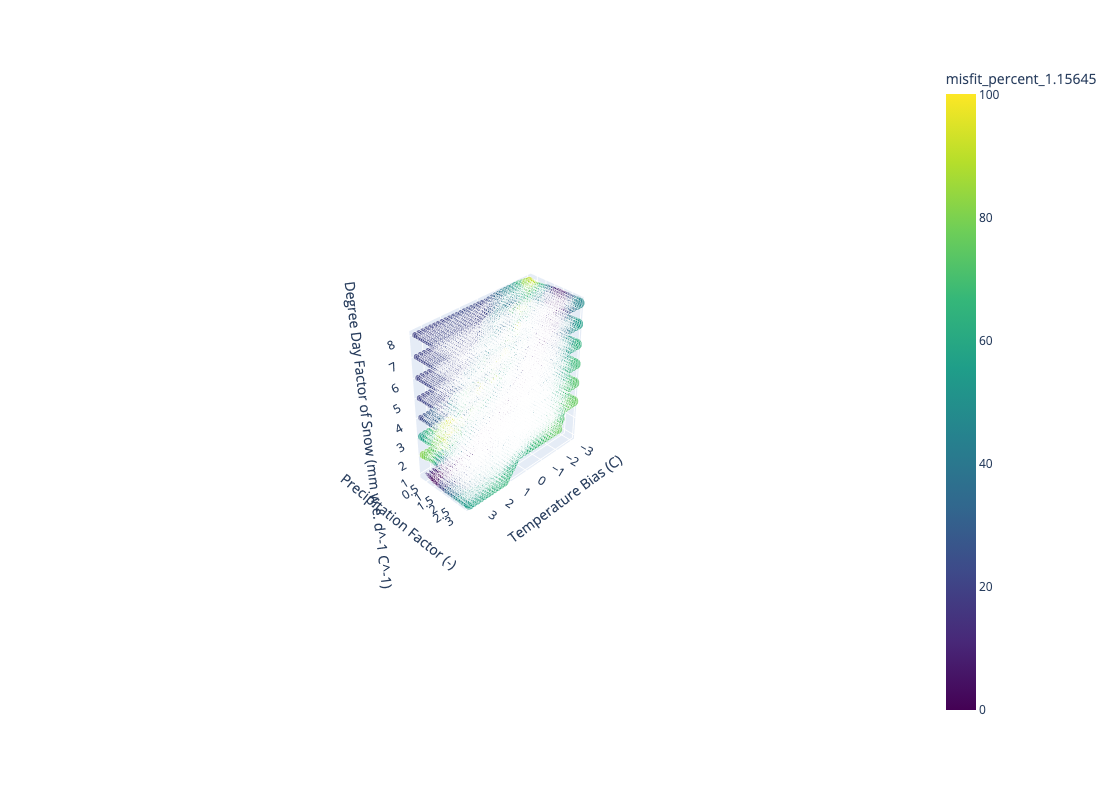

In [101]:
fig = px.scatter_3d(misfitdfs_merge, x='tbias', y='kp', z='ddfsnow',
                    color='misfit_percent_'+glac_nos[0], size='misfit_percent_'+glac_nos[1],
                    color_continuous_scale=px.colors.sequential.Viridis, labels={
                     'tbias': 'Temperature Bias (C)',
                     'ddfsnow': 'Degree Day Factor of Snow (mm w.e. d^-1 C^-1)',
                     'kp': 'Precipitation Factor (-)',
                     'misfit_'+glac_nos[0]: 'misfit '+glac_nos[0],
                     'misfit_'+glac_nos[1]: 'misfit '+glac_nos[1]})

fig.update_layout(autosize=True, width=800, height=800)
fig.show()

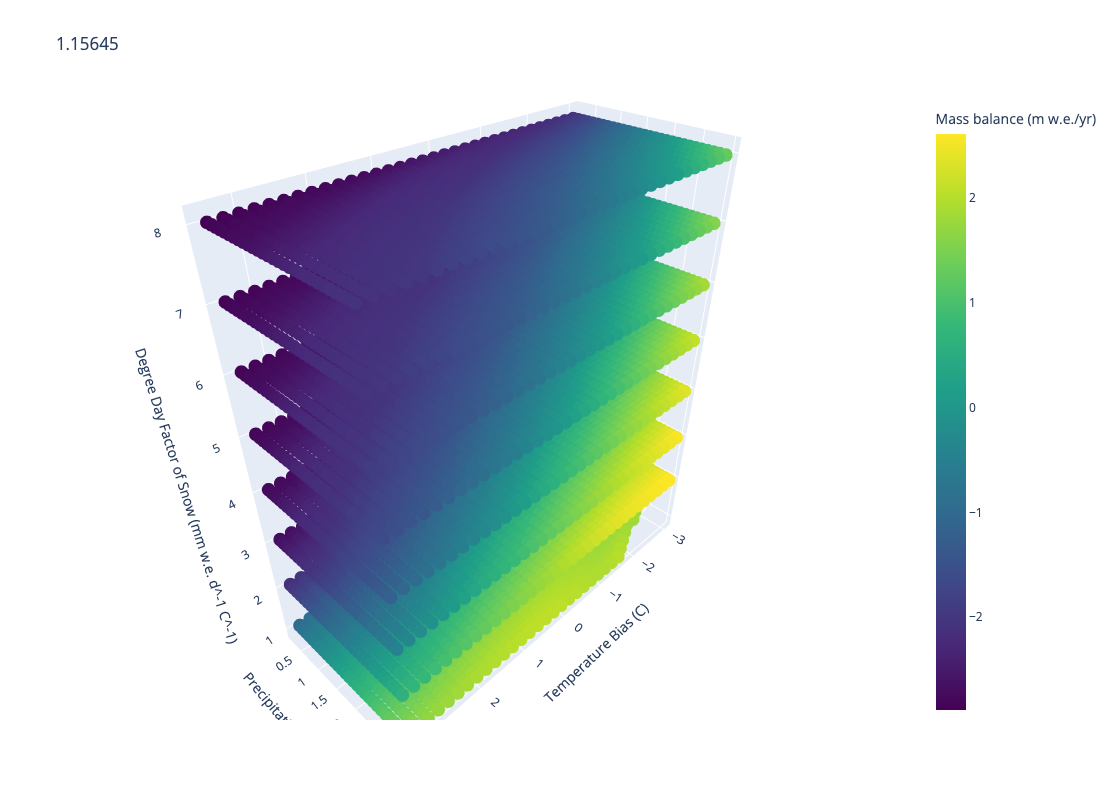

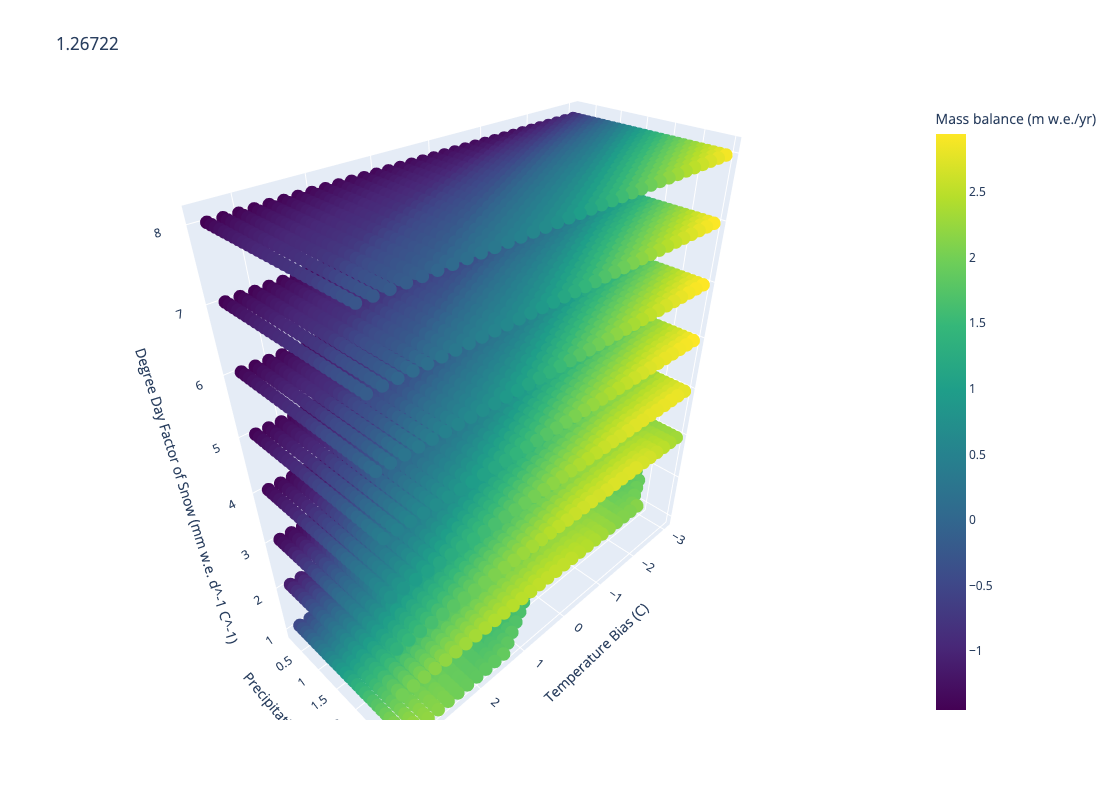

In [102]:
for misfitdf in misfitdfs:
    fig = px.scatter_3d(misfitdf, x='tbias', y='kp', z='ddfsnow',
                        color='mb', color_continuous_scale=px.colors.sequential.Viridis, labels={
                         'tbias': 'Temperature Bias (C)',
                         'ddfsnow': 'Degree Day Factor of Snow (mm w.e. d^-1 C^-1)',
                         'kp': 'Precipitation Factor (-)',
                         'mb': 'Mass balance (m w.e./yr)'}, title=misfitdf['glacno'][0])
    
    fig.update_layout(autosize=True, width=800, height=800)
    fig.show()


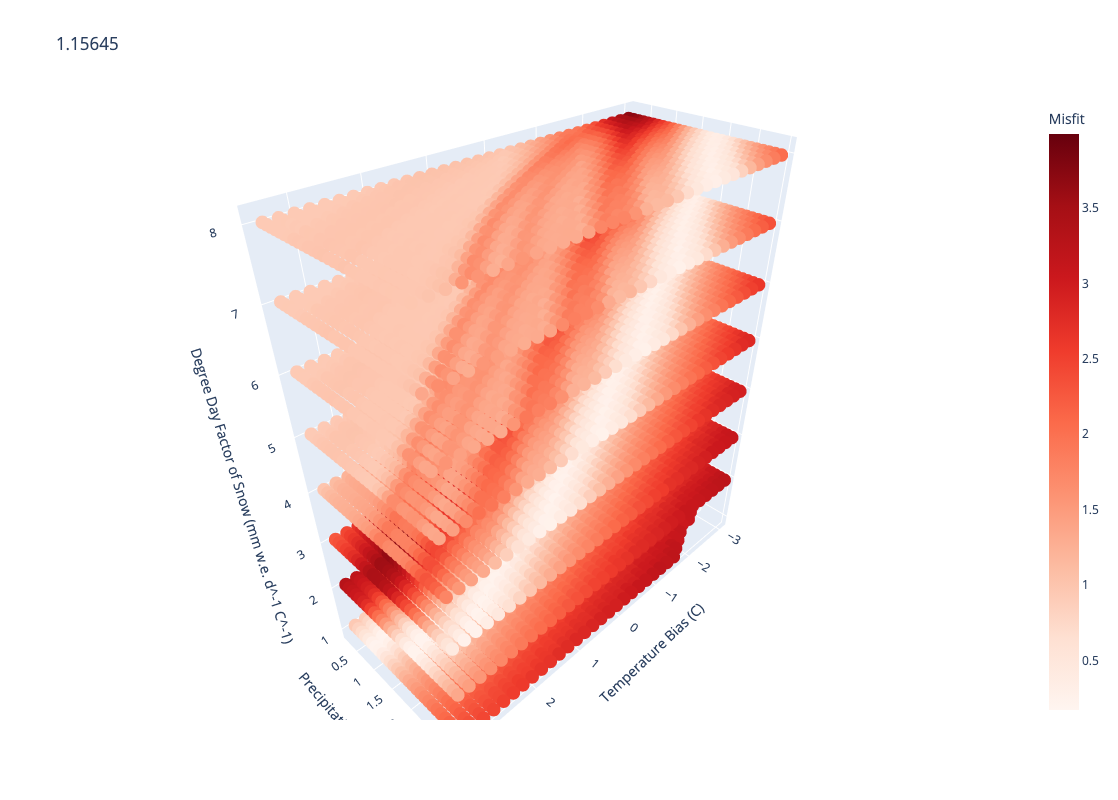

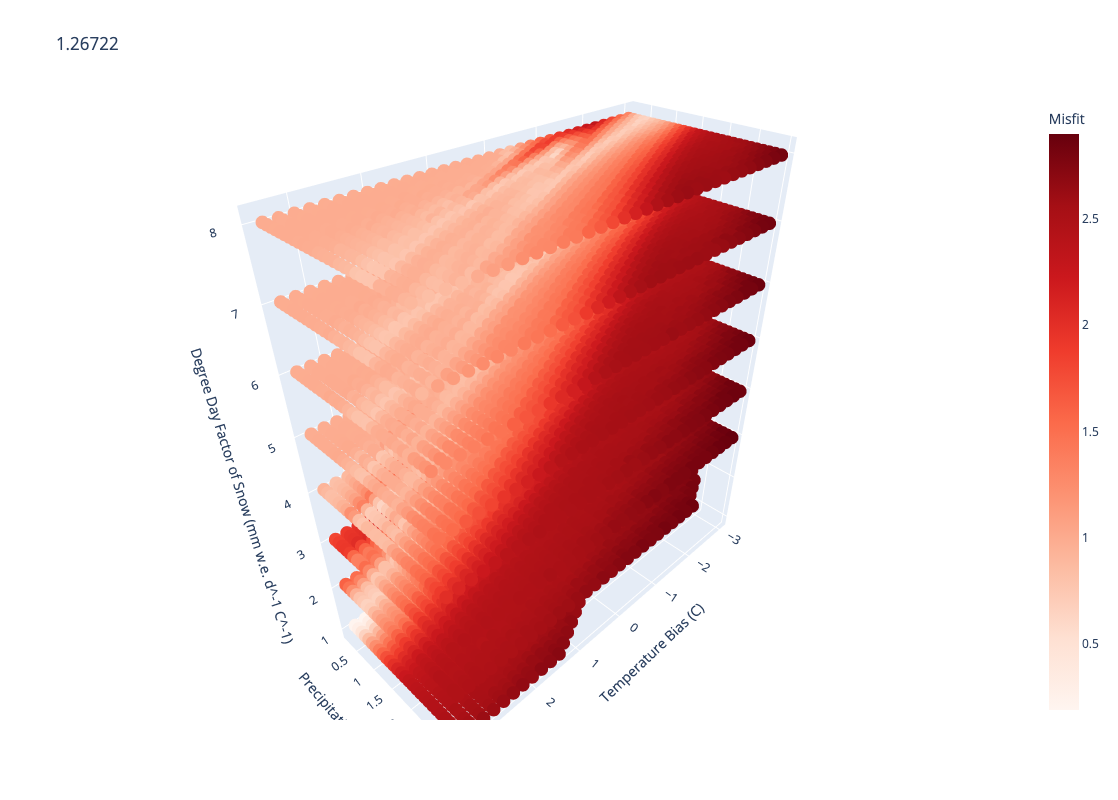

In [103]:
for misfitdf in misfitdfs:
    fig = px.scatter_3d(misfitdf, x='tbias', y='kp', z='ddfsnow',
                        color='misfit', color_continuous_scale=px.colors.sequential.Reds, labels={
                         "tbias": 'Temperature Bias (C)',
                         "ddfsnow": 'Degree Day Factor of Snow (mm w.e. d^-1 C^-1)',
                         "kp": 'Precipitation Factor (-)',
                         "misfit": 'Misfit'}, title=misfitdf['glacno'][0])
    
    fig.update_layout(autosize=True, width=800, height=800)
    fig.show()


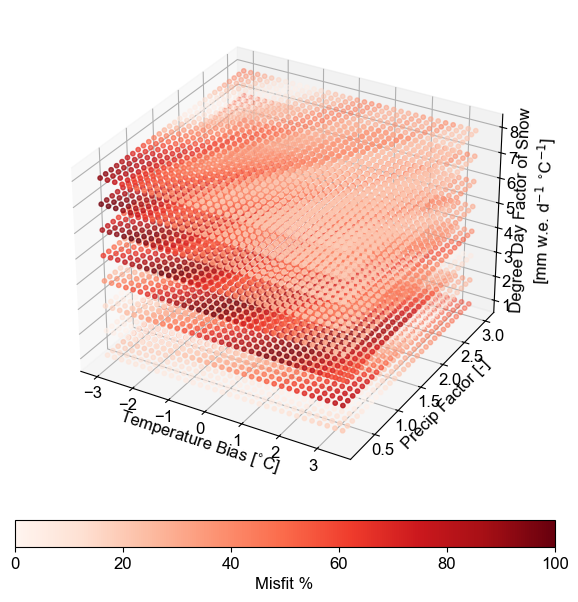

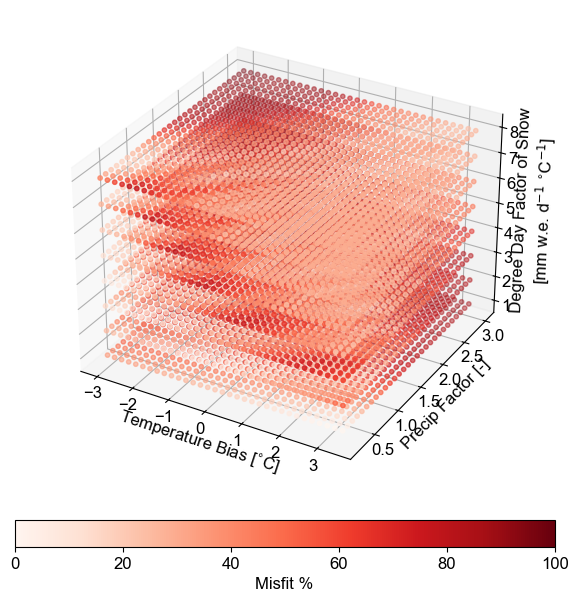

In [104]:
for misfitdf, glacno in zip(misfitdfs, glac_nos):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, gridspec_kw=dict(top=1.05, bottom=.05, left=-.05, right=.85), 
                           figsize=(8,6))
    
    s = 10
    pad=.2
    pad = '10%'
    size = '3%'
    
    c = ax.scatter(xs=misfitdf['tbias'], ys=misfitdf['kp'], zs=misfitdf['ddfsnow'], c=misfitdf['misfit_percent'], cmap=plt.cm.Reds, s=s)
    
    ax.set_xlabel(r'Temperature Bias [$^{\circ}$C]', labelpad=-7)
    ax.set_ylabel('Precip Factor [-]', labelpad=-7)
    ax.set_zlabel('Degree Day Factor of Snow\n' + r'[mm w.e. d$^{-1}$ $^{\circ}$C$^{-1}$]', labelpad=-5)
    ax.tick_params(axis="x", pad=-3) # (+) Added
    ax.tick_params(axis="y", pad=-3) # (+) Added
    ax.tick_params(axis="z", pad=-3) # (+) Added
    
    fig.colorbar(c, label=r'Misfit %', pad=.05,shrink=.75, orientation='horizontal') # an example
    os.makedirs(f'/Users/albinwells/Desktop/PyGEM-docs/Output/simulations/gridsearch/figs/{glacno}/', exist_ok=True)
    fig.savefig(f'/Users/albinwells/Desktop/PyGEM-docs/Output/simulations/gridsearch/figs/{glacno}/{glacno}_misfit.png',dpi=300)


# Show by lowest misfit between PyGEM and DEM $dhdt$ for both glaciers

In [106]:
print('Total values:', len(misfitdfs_merge))


Total values: 7414


In [107]:
misfitdfs_merge.sort_values(by=['misfit_mean']).head(10)


kp  tbias  ddfsnow  mb_1.15645  misfit_1.15645  misfit_percent_1.15645  \
5766  0.2    2.0      1.0   -0.694072        0.597737               11.139043   
6842  0.2    2.4      1.0   -0.763364        0.689655               13.546061   
320   0.2    2.2      1.0   -0.728219        0.644595               12.366093   
1256  0.2    1.8      1.0   -0.660876        0.557816               10.093663   
4461  0.2    1.6      1.0   -0.628575        0.518879                9.074035   
972   0.2    2.6      1.0   -0.799157        0.740089               14.866763   
2517  0.2    1.4      1.0   -0.596641        0.481041                8.083182   
4172  0.2    2.8      1.0   -0.835003        0.784537               16.030687   
5145  0.2    1.2      1.0   -0.565104        0.450641                7.287127   
3614  0.2    1.0      1.0   -0.534518        0.430795                6.767424   

      misfit_rank_1.15645  dhdt_match_1.15645  mb_1.26722  misfit_1.26722  \
5766                953.0                   0   -0.304862        0.375045   
6842               1106.0                   0   -0.349394        0.283942   
320                1032.0                   0   -0.326991        0.329706   
1256                884.0                   0   -0.283021        0.419302   
4461                804.0                   0   -0.261649        0.462332   
972                1191.0                   0   -0.372122        0.242669   
2517                731.0                   0   -0.240564        0.504342   
4172               1274.0                   0   -0.395327        0.209346   
5145                665.0                   0   -0.219693        0.545274   
3614                616.0                   0   -0.199143        0.584128   

      misfit_percent_1.26722  misfit_rank_1.26722  dhdt_match_1.26722  \
5766                6.826493                 27.0                   0   
6842                3.464506                  8.0                   0   
320                 5.153329                 14.0                   0   
1256                8.459684                 34.0                   0   
4461               10.047621                 50.0                   0   
972                 1.941426                  5.0                   0   
2517               11.597920                 67.0                   0   
4172                0.711701                  4.0                   0   
5145               13.108438                 81.0                   0   
3614               14.542233                100.0                   0   

      misfit_mean  misfit_rank_mean  misfit_percent_mean  
5766     0.486391             490.0             8.982768  
6842     0.486798             557.0             8.505284  
320      0.487150             523.0             8.759711  
1256     0.488559             459.0             9.276673  
4461     0.490605             427.0             9.560828  
972      0.491379             598.0             8.404094  
2517     0.492691             399.0             9.840551  
4172     0.496941             639.0             8.371194  
5145     0.497958             373.0            10.197782  
3614     0.507461             358.0            10.654828

In [108]:
misfitdfs_merge.sort_values(by=['misfit_percent_mean']).head(10)


kp  tbias  ddfsnow  mb_1.15645  misfit_1.15645  misfit_percent_1.15645  \
4172  0.2    2.8      1.0   -0.835003        0.784537               16.030687   
972   0.2    2.6      1.0   -0.799157        0.740089               14.866763   
6842  0.2    2.4      1.0   -0.763364        0.689655               13.546061   
1803  0.2    3.0      1.0   -0.872048        0.834046               17.327161   
320   0.2    2.2      1.0   -0.728219        0.644595               12.366093   
5766  0.2    2.0      1.0   -0.694072        0.597737               11.139043   
1256  0.2    1.8      1.0   -0.660876        0.557816               10.093663   
7039  0.2    3.2      1.0   -0.909395        0.885197               18.666634   
4461  0.2    1.6      1.0   -0.628575        0.518879                9.074035   
2517  0.2    1.4      1.0   -0.596641        0.481041                8.083182   

      misfit_rank_1.15645  dhdt_match_1.15645  mb_1.26722  misfit_1.26722  \
4172               1274.0                   0   -0.395327        0.209346   
972                1191.0                   0   -0.372122        0.242669   
6842               1106.0                   0   -0.349394        0.283942   
1803               1346.0                   0   -0.418858        0.190060   
320                1032.0                   0   -0.326991        0.329706   
5766                953.0                   0   -0.304862        0.375045   
1256                884.0                   0   -0.283021        0.419302   
7039               1430.0                   0   -0.442776        0.191151   
4461                804.0                   0   -0.261649        0.462332   
2517                731.0                   0   -0.240564        0.504342   

      misfit_percent_1.26722  misfit_rank_1.26722  dhdt_match_1.26722  \
4172                0.711701                  4.0                   0   
972                 1.941426                  5.0                   0   
6842                3.464506                  8.0                   0   
1803                0.000000                  1.0                   0   
320                 5.153329                 14.0                   0   
5766                6.826493                 27.0                   0   
1256                8.459684                 34.0                   0   
7039                0.040269                  2.0                   0   
4461               10.047621                 50.0                   0   
2517               11.597920                 67.0                   0   

      misfit_mean  misfit_rank_mean  misfit_percent_mean  
4172     0.496941             639.0             8.371194  
972      0.491379             598.0             8.404094  
6842     0.486798             557.0             8.505284  
1803     0.512053             673.5             8.663580  
320      0.487150             523.0             8.759711  
5766     0.486391             490.0             8.982768  
1256     0.488559             459.0             9.276673  
7039     0.538174             716.0             9.353451  
4461     0.490605             427.0             9.560828  
2517     0.492691             399.0             9.840551

In [109]:
misfitdfs_merge.sort_values(by=['misfit_rank_mean']).head(10)


kp  tbias  ddfsnow  mb_1.15645  misfit_1.15645  misfit_percent_1.15645  \
3614  0.2    1.0      1.0   -0.534518        0.430795                6.767424   
6108  0.2    0.8      1.0   -0.504998        0.421818                6.532363   
5528  0.3    1.6      1.0   -0.522452        0.406913                6.142042   
2893  0.2    0.6      1.0   -0.475969        0.403836                6.061461   
5145  0.2    1.2      1.0   -0.565104        0.450641                7.287127   
412   0.3    1.8      1.0   -0.555755        0.440798                7.029356   
3293  0.3    1.4      1.0   -0.490081        0.387992                5.646562   
4315  0.3    1.2      1.0   -0.458699        0.370821                5.196921   
2517  0.2    1.4      1.0   -0.596641        0.481041                8.083182   
6561  0.3    2.0      1.0   -0.589326        0.474949                7.923672   

      misfit_rank_1.15645  dhdt_match_1.15645  mb_1.26722  misfit_1.26722  \
3614                616.0                   0   -0.199143        0.584128   
6108                592.0                   0   -0.178902        0.622456   
5528                557.0                   0   -0.143128        0.650876   
2893                547.0                   0   -0.158631        0.660652   
5145                665.0                   0   -0.219693        0.545274   
412                 638.0                   0   -0.164866        0.609559   
3293                512.0                   0   -0.121636        0.690645   
4315                471.0                   0   -0.100291        0.730295   
2517                731.0                   0   -0.240564        0.504342   
6561                717.0                   0   -0.186905        0.566675   

      misfit_percent_1.26722  misfit_rank_1.26722  dhdt_match_1.26722  \
3614               14.542233                100.0                   0   
6108               15.956650                127.0                   0   
5528               17.005440                163.0                   0   
2893               17.366194                179.0                   0   
5145               13.108438                 81.0                   0   
412                15.480715                116.0                   0   
3293               18.473016                246.0                   0   
4315               19.936218                323.0                   0   
2517               11.597920                 67.0                   0   
6561               13.898172                 89.0                   0   

      misfit_mean  misfit_rank_mean  misfit_percent_mean  
3614     0.507461             358.0            10.654828  
6108     0.522137             359.5            11.244506  
5528     0.528895             360.0            11.573741  
2893     0.532244             363.0            11.713827  
5145     0.497958             373.0            10.197782  
412      0.525178             377.0            11.255036  
3293     0.539318             379.0            12.059789  
4315     0.550558             397.0            12.566570  
2517     0.492691             399.0             9.840551  
6561     0.520812             403.0            10.910922

In [110]:
# sort parameter sets by log(misfit)
for misfitdf in misfitdfs:
    print(misfitdf.sort_values(by=['misfit']).head(10))


       glacno   kp  tbias  ddfsnow        mb    misfit  misfit_percent  \
7346  1.15645  1.1    0.8      2.0 -0.287019  0.172363        0.000000   
2944  1.15645  1.0    0.6      2.0 -0.332330  0.172934        0.014951   
7475  1.15645  1.2    1.2      2.0 -0.313118  0.172970        0.015902   
6127  1.15645  0.6   -2.8      3.0 -0.279731  0.174529        0.056706   
6636  1.15645  0.8   -0.2      2.0 -0.317653  0.175956        0.094081   
2732  1.15645  0.7   -2.4      3.0 -0.276556  0.176501        0.108353   
7271  1.15645  1.3    1.6      2.0 -0.347346  0.176515        0.108710   
6557  1.15645  0.9    0.2      2.0 -0.320532  0.176877        0.118194   
5673  1.15645  1.4    1.8      2.0 -0.315138  0.179428        0.185004   
2647  1.15645  1.1    1.0      2.0 -0.353198  0.179890        0.197091   

      misfit_rank  dhdt_match  
7346          1.0           1  
2944          2.0           1  
7475          3.0           1  
6127          4.0           1  
6636          5.0        

In [111]:
# # sort parameter sets by log(misfit)
# for misfitdf in misfitdfs:
#     print(misfitdf.sort_values(by=['misfit']).tail(10))

In [123]:
tmp_df = misfitdfs[1].copy()
tmp_df = tmp_df[tmp_df['dhdt_match'] == 1]
tmp_df

glacno   kp  tbias  ddfsnow        mb    misfit  misfit_percent  \
161   1.26722  0.6    1.4      2.0 -0.251601  0.668437       17.653476   
414   1.26722  0.9    3.0      2.0 -0.245728  0.878000       25.386979   
585   1.26722  0.5   -3.0      6.0 -0.221036  0.760307       21.043749   
651   1.26722  0.4   -2.4      4.0 -0.202421  0.558506       13.596706   
851   1.26722  0.4   -1.4      3.0 -0.229037  0.531933       12.616105   
917   1.26722  0.6   -2.0      5.0 -0.250849  0.781660       21.831740   
1140  1.26722  0.3   -1.8      3.0 -0.270831  0.431276        8.901582   
1277  1.26722  0.4   -2.8      5.0 -0.269261  0.612864       15.602685   
1290  1.26722  0.3   -2.8      4.0 -0.232859  0.457321        9.862686   
1379  1.26722  0.6   -1.2      4.0 -0.279573  0.774793       21.578339   
1526  1.26722  0.8    2.6      2.0 -0.275728  0.850329       24.365815   
1738  1.26722  0.5   -1.8      4.0 -0.240053  0.700870       18.850366   
1900  1.26722  0.7    0.0      3.0 -0.199760  0.859584       24.707349   
2297  1.26722  0.6   -2.4      6.0 -0.285371  0.683807       18.220674   
2315  1.26722  0.4    0.2      2.0 -0.252619  0.476255       10.561410   
2956  1.26722  0.6   -0.2      3.0 -0.274963  0.774074       21.551803   
3306  1.26722  0.5   -0.8      3.0 -0.245866  0.646463       16.842575   
3405  1.26722  0.6   -2.8      7.0 -0.283502  0.676265       17.942376   
3481  1.26722  0.5   -2.6      5.0 -0.195556  0.713380       19.312010   
3728  1.26722  0.6   -0.4      3.0 -0.221870  0.760907       21.065912   
3766  1.26722  0.4   -3.0      5.0 -0.202591  0.583043       14.502191   
3772  1.26722  0.6   -2.6      6.0 -0.221422  0.781495       21.825638   
4023  1.26722  0.5   -1.6      4.0 -0.299132  0.729827       19.918954   
4084  1.26722  0.7    0.2      3.0 -0.251240  0.819705       23.235704   
4566  1.26722  0.3   -2.6      4.0 -0.286035  0.459643        9.948389   
4825  1.26722  0.7   -0.8      4.0 -0.260501  0.737929       20.217942   
5125  1.26722  0.7    2.0      2.0 -0.263786  0.774134       21.554026   
5398  1.26722  0.5   -2.4      5.0 -0.261735  0.751880       20.732757   
5488  1.26722  0.5   -2.8      6.0 -0.289706  0.730278       19.935608   
5654  1.26722  0.5   -0.6      3.0 -0.299105  0.660266       17.351962   
5772  1.26722  0.2   -2.6      3.0 -0.238047  0.447483        9.499639   
5841  1.26722  0.6   -1.4      4.0 -0.223330  0.817631       23.159180   
5893  1.26722  0.3   -2.0      3.0 -0.226835  0.446499        9.463327   
6091  1.26722  0.6   -2.2      5.0 -0.189175  0.830807       23.645413   
6346  1.26722  0.6   -3.0      7.0 -0.214025  0.738772       20.249049   
6951  1.26722  0.5    0.8      2.0 -0.247644  0.569991       14.020558   
6982  1.26722  0.4   -2.2      4.0 -0.259116  0.574134       14.173445   
7206  1.26722  0.8    2.4      2.0 -0.233115  0.875809       25.306108   
7283  1.26722  0.4   -1.2      3.0 -0.277356  0.535964       12.764869   

      misfit_rank  dhdt_match  
161         198.0           1  
414         984.0           1  
585         426.0           1  
651          86.0           1  
851          76.0           1  
917         533.0           1  
1140         39.0           1  
1277        121.0           1  
1290         46.0           1  
1379        493.0           1  
1526        817.0           1  
1738        260.0           1  
1900        865.0           1  
2297        231.0           1  
2315         55.0           1  
2956        489.0           1  
3306        159.0           1  
3405        216.0           1  
3481        278.0           1  
3728        429.0           1  
3766         99.0           1  
3772        531.0           1  
4023        321.0           1  
4084        670.0           1  
4566         47.0           1  
4825        345.0           1  
5125        490.0           1  
5398        389.0           1  
5488        322.0           1  
5654        177.0           1  
5772         45.0           1  
5841        658.0     

# Select & plot optimal parameter set

In [116]:
stats_for = 'kenn' # 'merged', 'kenn', 'root'
if stats_for == 'merged':
    tmp_df = misfitdfs_merge.copy() # Merged
    tmp_df = tmp_df[tmp_df['misfit_percent_mean'] < 20]
elif stats_for == 'kenn':    
    tmp_df = misfitdfs[0].copy() # Kenn
    tmp_df = tmp_df[tmp_df['dhdt_match'] == 1]
    tmp_df = tmp_df[tmp_df['misfit_percent'] < 10]
elif stats_for == 'root':
    tmp_df = misfitdfs[1].copy() # Root
    tmp_df = tmp_df[tmp_df['dhdt_match'] == 1]
    tmp_df = tmp_df[tmp_df['misfit_percent'] < 10]

# compute statistics
mean_kp, std_kp = tmp_df['kp'].mean(), tmp_df['kp'].std()
mean_tb, std_tb = tmp_df['tbias'].mean(), tmp_df['tbias'].std()
mean_fs, std_fs = tmp_df['ddfsnow'].mean(), tmp_df['ddfsnow'].std()

print('Observations:', len(tmp_df))
print('\t\tMean\tStDev')
print(f"kp:\t\t{mean_kp:.3f}\t{std_kp:.3f}")
print(f"tbias:\t\t{mean_tb:.3f}\t{std_tb:.3f}")
print(f"ddfsnow:\t{mean_fs:.3f}\t{std_fs:.3f}")


Observations: 89
		Mean	StDev
kp:		0.908	0.396
tbias:		-0.128	1.966
ddfsnow:	2.191	0.877


In [117]:
# save df of "good" params
tmp_df.to_csv(f'simulations/opt_params/{stats_for}_opt_params.csv', index=False)
